## References:
1. [Hugginface](https://huggingface.co/CAMeL-Lab/bert-base-arabic-camelbert-mix)
2. [Sentiment Analysis with BERT](https://colab.research.google.com/drive/1PHv-IRLPCtv7oTcIGbsgZHqrB5LPvB7S#scrollTo=PGnlRWvkY-2c)

In [1]:
import os
import random
import transformers
from transformers import AutoModel, AutoTokenizer, AdamW, get_linear_schedule_with_warmup
from transformers import BertTokenizer, BertModel

import torch
import math
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

#device = torch.device("cpu")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device


device(type='cuda', index=0)

In [2]:
class_names = ['not_sarcastic', 'sarcastic']

In [3]:
path="./"

TypeI=""
TypeII="TweetPreprocessed."
TypeIII="HalfPreprocessed."
TypeIV="FullyPreprocessed."

path0="TaskC.Ar.train.NotAugmented."
path1="TaskC.Ar.train.Augmented.Embedding."
path2="TaskC.Ar.train.Augmented.NotEmbedding."

pathVal="TaskC.Ar.Basic.Val."
pathTest="TaskC.Ar.Basic.Test."

In [4]:
chosenPath=path2
ChosenType=TypeII
print(chosenPath)
print(ChosenType)

df_train = pd.read_csv(path + chosenPath + ChosenType + "csv")
df_train.dropna(subset = ["tweet"], inplace=True)
df_val = pd.read_csv(path + pathVal + ChosenType + "csv")
df_val.dropna(subset = ["tweet"], inplace=True)
df_test = pd.read_csv(path + pathTest + ChosenType + "csv")
df_test.dropna(subset = ["tweet"], inplace=True)
print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

TaskC.Ar.train.Augmented.NotEmbedding.
TweetPreprocessed.
(1521, 5)
(298, 5)
(200, 5)


In [5]:
df_train

,tweet_id,tweet,sarcastic,rephrase,dialect
0,279.0,الأيفون غالى ومش هعرف أجيبه غير لما موديله يقدم,0,الحمدلله ايفون 8 كدا سعره هينزل ابقي اجيبه بقي,nile
1,NaN,الوضع لوز,1,الوضع ممتاز,levant
2,NaN,مؤكد العربية ديه حتنطلق للخلف بتوجيهاتكم,1,لن تستطيعوا تصنيع السيارة لانكم فاشلون جدا,nile
3,NaN,صاحبي ده يقولي انا خلاص دقيقتن واكون قدامك فعل...,1,بيكون نايم ف السرير لسه ويقولي دقيقتين وهكون ق...,nile
4,714.0,عايزين تعرفوا الشروط هوا شرط واحد يستخدم فى كل...,1,الواسطة هي اهم شيء للعمل,nile
...,...,...,...,...,...
1516,NaN,مستنين شهر أبريل عشان يكذبون فيه على أساس أنهم...,1,هما مش فارق معاهم اى شهر فى السنه بيكذبو على طول,nile
1517,NaN,مفيش راجل بيدافع عن حد دلوقتى,0,الرجاله ماتت في الحرب,nile
1518,11.0,سنة أغسطس بيكون فيها فجوة زمنية مجهولة الأيام ...,1,شهر اغسطس يبدو طويلا جدا,nile
1519,245.0,الشعب المغربي يركع لغير الله و فرحان,0,حنا الماليك تعنا يعطينا البنان عاش الماليك هههه,magreb


In [6]:
df_val

,tweet_id,tweet,sarcastic,rephrase,dialect
0,6,الدنيا عاملة زى اوضة وصالة كل ما امشى فى حته ا...,1,الدنيا صغيرة ودايما نلاقى فيها حد نعرفه,nile
1,218,لا وانت الشهادة لله وفي اوي,1,انت خائن,nile
2,92,من قير كوكا لا تحدثني عل قاز هذا راه بيت شعري,1,كوكاكولا أفضل مشروب,magreb
3,76,السعودية : لا أعرفه ، لذا لن أضيفه .المصرية :ا...,1,ان المصريين بيضيفوا ناس كتير على مواقع التواصل,nile
4,244,ساصدق قزانة الدشرة و مانامنش اتصالات الجزائر ا...,1,أتصالات الجزائر كادبين,magreb
...,...,...,...,...,...
293,6,الدنيا عاملة زى اوضة وصالة كل ما امشى فى حته ا...,1,الدنيا صغيرة ودايما نلاقى فيها حد نعرفه,nile
294,521,يا عم ده جلده ومش بيطلع جنيه,1,الشخص ده بخيل جدا,nile
295,450,فلورنتينو بيريز رايح يعطي كأس شامبينز ليڨ للخل...,1,فلورنتينو بيريز باغي يشري مبامبي من البياسجي ب...,magreb
296,65,ياخبر النهارده بفلوس بكره يبقى ببلاش,1,اى ان ما استعجلت عليه وتريد دفع فيه المال بالص...,nile


In [7]:
df_test

,tweet_id,tweet,sarcastic,rephrase,dialect
0,NaN,يا زبدة لا تسيحي/ تذوبي,0,يا دهينة لا تنكتين,NaN
1,NaN,ياسمين صبرى مش كويسة فى التمثيل,0,مين اللي أقنع ياسمين صبري أنها تمثل,NaN
2,NaN,ابو بلاش كتر منه كتير,1,الشئ المجانى خذ منه كتير لانه غنيمه,NaN
3,NaN,انت متكبر لكن لا تملك ما يدفعك للتكبر,0,تحسب نفسك حاجة و انت متسواش نص دجاجة,NaN
4,NaN,معنديش فكه تاخد برميل بترول,1,سعر البترول يصل لادني مستوي,NaN
...,...,...,...,...,...
195,NaN,الراجل اللى مش معاه فلوس ملوش لازمة,0,شنب ماتحته فلوس يحتاج موس,NaN
196,NaN,قبل الجواز اغسل وش مراتك,1,لاز تشوف مراتك قبل الجواز بدون ميكب,NaN
197,NaN,شخص ليس له اي جدوي,0,يالك مش شخص عظيم جدا,NaN
198,NaN,معنديش مانع اخدك علي قد عقلك بس الاقيه الاول,1,معنديش مانع اتكلم معاك بس انت معندكش فكر اصلا,NaN


In [8]:
print(df_test)

     tweet_id                                         tweet  sarcastic  \
0         NaN                       يا زبدة لا تسيحي/ تذوبي          0   
1         NaN               ياسمين صبرى مش كويسة فى التمثيل          0   
2         NaN                         ابو بلاش كتر منه كتير          1   
3         NaN         انت متكبر لكن لا تملك ما يدفعك للتكبر          0   
4         NaN                   معنديش فكه تاخد برميل بترول          1   
..        ...                                           ...        ...   
195       NaN           الراجل اللى مش معاه فلوس ملوش لازمة          0   
196       NaN                      قبل الجواز اغسل وش مراتك          1   
197       NaN                            شخص ليس له اي جدوي          0   
198       NaN  معنديش مانع اخدك علي قد عقلك بس الاقيه الاول          1   
199       NaN       قلبي على ولدى انفطر ، وقلب ولدى على حجر          1   

                                              rephrase  dialect  
0                                   يا دهينة 

test total 200 sarcastic 100 non sarcastic 100


/home/sknigam/anaconda3/envs/tweeter/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0, 0, 'not_sarcastic'), Text(1, 0, 'sarcastic')]

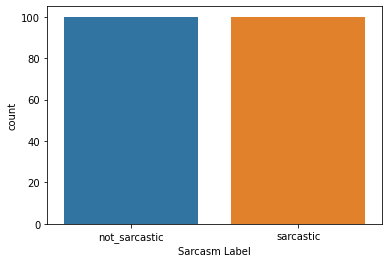

In [9]:
ax = sns.countplot(df_test.sarcastic)
s_t = 0
ns_t =0
for i in df_test.sarcastic:
    if i == 1:
        s_t+=1
    else:
        ns_t+=1
l_count = len(df_test.sarcastic)
print("test total", l_count, "sarcastic", s_t, "non sarcastic", ns_t)
plt.xlabel('Sarcasm Label')

ax.set_xticklabels(class_names)


Val total 298 sarcastic 186 non sarcastic 112


/home/sknigam/anaconda3/envs/tweeter/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


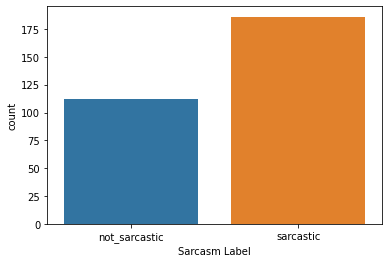

In [10]:
ax = sns.countplot(df_val.sarcastic)
plt.xlabel('Sarcasm Label')
ax.set_xticklabels(class_names);
s_t = 0
ns_t =0
for i in df_val.sarcastic:
    if i == 1:
        s_t+=1
    else:
        ns_t+=1
l_count = len(df_val.sarcastic)
print("Val total", l_count, "sarcastic", s_t, "non sarcastic", ns_t)

train total 1521 sarcastic 759 non sarcastic 762


/home/sknigam/anaconda3/envs/tweeter/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


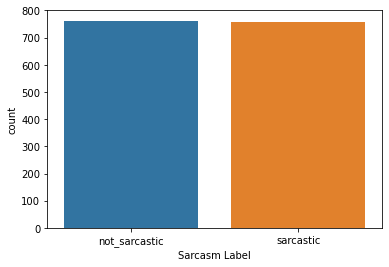

In [11]:
ax = sns.countplot(df_train.sarcastic)
plt.xlabel('Sarcasm Label')
ax.set_xticklabels(class_names)
s_t = 0
ns_t =0
for i in df_train.sarcastic:
    if i == 1:
        s_t+=1
    else:
        ns_t+=1
l_count = len(df_train.sarcastic)
print("train total", l_count, "sarcastic", s_t, "non sarcastic", ns_t)

In [12]:
PRE_TRAINED_MODEL_NAME = 'CAMeL-Lab/bert-base-arabic-camelbert-mix'
bertweet = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Some weights of the model checkpoint at CAMeL-Lab/bert-base-arabic-camelbert-mix were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


> You can use a cased and uncased version of BERT and tokenizer. I've experimented with both. The cased version works better. Intuitively, that makes sense, since "BAD" might convey more sarcasm than "bad".

In [13]:
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME, normalization=True)

In [14]:
MAX_LEN = 150

In [15]:
class GPTweetDataset(Dataset):

  def __init__(self, tweets, targets, tokenizer, max_len):
    self.tweets = tweets
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.tweets)
  
  def __getitem__(self, item):
    tweet = str(self.tweets[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      tweet,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    
    return {
      'tweet_text': tweet,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [16]:
df_train.shape, df_val.shape, df_test.shape

((1521, 5), (298, 5), (200, 5))

We also need to create a couple of data loaders. Here's a helper function to do it:

In [17]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  tweets=[]
  for index, row in df.iterrows():
    text=str(row['tweet'])+tokenizer.sep_token+str(row['rephrase'])
    tweets.append(text)
    
  ds = GPTweetDataset(
    tweets=tweets,
    targets=df.sarcastic.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [18]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [19]:
data = next(iter(train_data_loader))
data.keys()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/sknigam/anaconda3/envs/tweeter/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2211: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'

dict_keys(['tweet_text', 'input_ids', 'attention_mask', 'targets'])

In [20]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 150])
torch.Size([16, 150])
torch.Size([16])


In [21]:
class SarcasmClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SarcasmClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask, return_dict=False)
    output = self.drop(pooled_output)
    return self.out(output)

In [22]:
model = SarcasmClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at CAMeL-Lab/bert-base-arabic-camelbert-mix were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [23]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape)
print(attention_mask.shape)

torch.Size([16, 150])
torch.Size([16, 150])


In [24]:
print(input_ids.shape)
print(attention_mask.shape)
F.softmax(model(input_ids, attention_mask), dim=1)

torch.Size([16, 150])
torch.Size([16, 150])


tensor([[0.3028, 0.6972],
        [0.3035, 0.6965],
        [0.3300, 0.6700],
        [0.5875, 0.4125],
        [0.4583, 0.5417],
        [0.2805, 0.7195],
        [0.6214, 0.3786],
        [0.4565, 0.5435],
        [0.3520, 0.6480],
        [0.5057, 0.4943],
        [0.4918, 0.5082],
        [0.4593, 0.5407],
        [0.5094, 0.4906],
        [0.5085, 0.4915],
        [0.3489, 0.6511],
        [0.3927, 0.6073]], device='cuda:0', grad_fn=<SoftmaxBackward>)

### Training

In [25]:
EPOCHS = 5

optimizer = AdamW(model.parameters(), lr=3e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

#weights = [float(s_t)/(s_t+ns_t),float(2*ns_t)/(s_t+ns_t)] #as class distribution
#class_weights = torch.FloatTensor(weights).cuda()
#loss_fn = nn.CrossEntropyLoss(weight=class_weights,reduction='mean').to(device)

loss_fn = nn.CrossEntropyLoss().to(device) #CrossEntropyLoss() has already included a softmax layer inside.

In [26]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    
    outputs=[]
    try:
      outputs = model(
          input_ids=input_ids,
          attention_mask=attention_mask)
    except:
      print("An exception occurred")
      print("input_ids=",input_ids.shape, "attention_mask=" , attention_mask.shape)
      continue
    

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [27]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs=[]
      try:
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask)
      except:
        print("An exception occurred")
        print("input_ids=",input_ids.shape, "attention_mask=" , attention_mask.shape)
        continue
    

      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [28]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,    
        loss_fn, 
        optimizer, 
        device, 
        scheduler, 
        len(df_train)
      )

    print(f'Train loss {train_loss} accuracy {train_acc}')
    
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn, 
        device, 
        len(df_val)
      )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        best_accuracy = val_acc
  

Epoch 1/5
----------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Train loss 0.4550803956450788 accuracy 0.7712031558185405


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/sknigam/anaconda3/envs/tweeter/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2211: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'

Val   loss 0.5289297713653037 accuracy 0.8758389261744967

Epoch 2/5
----------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Train loss 0.04315572747183675 accuracy 0.9875082182774491


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/sknigam/anaconda3/envs/tweeter/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2211: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'

Val   loss 0.4467540739673208 accuracy 0.9429530201342282

Epoch 3/5
----------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Train loss 0.001279456351880981 accuracy 0.9993425378040763


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Val   loss 0.6117826016343315 accuracy 0.9228187919463087

Epoch 4/5
----------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Train loss 0.0061469252174977855 accuracy 0.9993425378040763


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/sknigam/anaconda3/envs/tweeter/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2211: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'

Val   loss 0.5098584998718012 accuracy 0.9228187919463087

Epoch 5/5
----------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Train loss 8.871035030703449e-05 accuracy 1.0


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Val   loss 0.5141519522522254 accuracy 0.9261744966442953

CPU times: user 55.7 s, sys: 5.36 s, total: 1min 1s
Wall time: 1min 3s


## Evaluation

In [29]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/sknigam/anaconda3/envs/tweeter/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2211: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Truncation was not explicitly activated but `max_length` is provided a spe

0.87

In [30]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  tweet_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["tweet_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      tweet_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return tweet_texts, predictions, prediction_probs, real_values

In [31]:
y_tweet_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  val_data_loader
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

In [32]:
print(classification_report(y_test, y_pred, target_names=class_names, digits=4))

               precision    recall  f1-score   support

not_sarcastic     0.9327    0.8661    0.8981       112
    sarcastic     0.9227    0.9624    0.9421       186

     accuracy                         0.9262       298
    macro avg     0.9277    0.9142    0.9201       298
 weighted avg     0.9264    0.9262    0.9256       298



In [33]:
y_tweet_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/sknigam/anaconda3/envs/tweeter/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2211: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Truncation was not explicitly activated but `max_length` is provided a spe

In [34]:
print(classification_report(y_test, y_pred, target_names=class_names, digits=4))

               precision    recall  f1-score   support

not_sarcastic     0.8936    0.8400    0.8660       100
    sarcastic     0.8491    0.9000    0.8738       100

     accuracy                         0.8700       200
    macro avg     0.8713    0.8700    0.8699       200
 weighted avg     0.8713    0.8700    0.8699       200



In [35]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.87